## Holidays
Sales prediction tasks are usually solved using the information of propotions / actions, state / regional / school / sports holidays.
None of those are present in the data, but can we figure out the holidays calendar using the information provided?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv', parse_dates=['dt'])
train.set_index(['id', 'dt'], inplace=True)
print(train.shape)
train.head()

(8230, 1)


target
id dt                
0  2016-01-02   747.8
   2016-01-03   681.2
   2016-01-04   505.8
   2016-01-06  1078.3
   2016-01-07   961.9

### which days are missing per store?

In [6]:
# will add missing values for store data
#  store_data: DataFrame for particular store, indexed by date
#  return: store_data with missing days filled
def add_missing_values(store_data):
    idx = pd.date_range(store_data.index.min(), store_data.index.max())
    store_data = store_data.reindex(idx)
    store_data.index.rename('dt', inplace=True)  
    return store_data

datas = []
store_ids = set(train.index.get_level_values(level='id'))
for store_id in store_ids:
    store_data = train.loc[store_id]
    store_data = add_missing_values(store_data)
    store_data['id'] = store_id
    datas.append(store_data.reset_index())

train = pd.concat(datas)
train.set_index(['id', 'dt'], inplace=True)
train.sort_index(inplace=True)
train

target
id dt                
0  2016-01-02   747.8
   2016-01-03   681.2
   2016-01-04   505.8
   2016-01-05     NaN
   2016-01-06  1078.3
...               ...
19 2017-06-26   358.4
   2017-06-27   278.5
   2017-06-28     NaN
   2017-06-29   739.1
   2017-06-30   629.7

[10920 rows x 1 columns]

In [8]:
# let us transpose the train so that n_stores of columns will 
# represent the sales at the particular store
index = pd.date_range(train.index.get_level_values(level='dt').min(), 
                      train.index.get_level_values(level='dt').max())
columns = sorted(list(store_ids))

train_transposed = pd.DataFrame(index=index, columns=['dow', 'wend'] + columns)
for store_id in store_ids:
    train_transposed[store_id] = train.loc[store_id].values
train_transposed['dow'] = train_transposed.index.weekday
train_transposed['wend'] = (train_transposed['dow'] >= 5)
train_transposed.to_csv('train_transposed.csv')
train_transposed

,dow,wend,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
2016-01-02,5,True,747.8,421.8,546.2,355.7,341.2,341.8,510.9,620.0,...,656.7,477.2,656.5,697.0,518.4,728.1,343.8,328.5,617.2,370.3
2016-01-03,6,True,681.2,427.1,549.3,418.1,326.0,367.5,548.3,605.3,...,674.4,446.7,685.1,711.2,528.4,758.0,361.6,331.1,523.4,382.3
2016-01-04,0,False,505.8,312.3,478.2,214.1,433.1,383.9,583.6,548.2,...,749.4,419.8,371.6,546.3,362.8,652.3,356.4,460.2,474.4,239.2
2016-01-05,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,2,False,1078.3,624.4,833.9,709.9,NaN,600.8,1010.6,756.2,...,NaN,904.6,NaN,NaN,1034.9,1254.4,492.3,NaN,NaN,723.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,0,False,627.8,457.3,472.9,464.8,293.9,369.6,543.9,595.8,...,590.5,368.1,632.9,674.6,532.8,751.6,396.6,366.5,504.0,358.4
2017-06-27,1,False,464.5,393.9,479.8,243.7,332.0,501.7,622.3,539.6,...,759.1,373.2,401.9,573.0,401.1,642.3,433.9,460.3,412.8,278.5
2017-06-28,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-29,3,False,1039.9,717.1,820.9,721.0,453.5,630.8,944.2,847.9,...,840.1,786.9,1472.9,977.7,951.0,1204.2,829.0,915.1,1029.9,739.1


from the analysis of the train_transposed.csv, we can see those days stores were unusually shut, not in the regular Tuesday / Wednesday day off:

In [49]:
unusual_offs = \
['2016-01-06', '2016-02-29', '2016-04-18', '2016-04-21', '2016-05-01', '2016-05-29',
 '2016-06-09', '2016-06-19', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01',
 '2017-04-03', '2017-04-06', '2017-05-01', '2017-05-14', '2017-05-25', '2017-06-04']

### world holidays data
let us pull the holidays data from open dataset:
<br>https://github.com/nager/Nager.Date
<br>https://date.nager.at/Api
<br>https://date.nager.at/PublicHoliday/Country/US/2019/CSV

In [11]:
countries = {'AD': 'Andorra','AL': 'Albania','AR': 'Argentina','AT': 'Austria','AU': 'Australia','AX': 'Åland Islands','BB': 'Barbados','BE': 'Belgium','BG': 'Bulgaria','BJ': 'Benin','BO': 'Bolivia','BR': 'Brazil','BS': 'Bahamas','BW': 'Botswana','BY': 'Belarus','BZ': 'Belize','CA': 'Canada','CH': 'Switzerland','CL': 'Chile','CN': 'China',
             'CO': 'Colombia','CR': 'Costa Rica','CU': 'Cuba','CY': 'Cyprus','CZ': 'Czechia','DE': 'Germany','DK': 'Denmark','DO': 'Dominican Republic','EC': 'Ecuador','EE': 'Estonia','EG': 'Egypt','ES': 'Spain','FI': 'Finland','FO': 'Faroe Islands','FR': 'France','GA': 'Gabon','GB': 'United Kingdom','GD': 'Grenada','GL': 'Greenland',
             'GM': 'Gambia','GR': 'Greece','GT': 'Guatemala','GY': 'Guyana','HN': 'Honduras','HR': 'Croatia','HT': 'Haiti','HU': 'Hungary','ID': 'Indonesia','IE': 'Ireland','IM': 'Isle of Man','IS': 'Iceland','IT': 'Italy','JE': 'Jersey','JM': 'Jamaica','JP': 'Japan','LI': 'Liechtenstein','LS': 'Lesotho','LT': 'Lithuania','LU': 'Luxembourg',
             'LV': 'Latvia','MA': 'Morocco','MC': 'Monaco','MD': 'Moldova','MG': 'Madagascar','MK': 'North Macedonia','MN': 'Mongolia','MT': 'Malta','MX': 'Mexico','MZ': 'Mozambique','NA': 'Namibia','NE': 'Niger','NI': 'Nicaragua','NL': 'Netherlands','NO': 'Norway','NZ': 'New Zealand','PA': 'Panama','PE': 'Peru','PL': 'Poland','PR': 'Puerto Rico',
             'PT': 'Portugal','PY': 'Paraguay','RO': 'Romania','RS': 'Serbia','RU': 'Russia','SE': 'Sweden','SI': 'Slovenia','SJ': 'Svalbard and Jan Mayen','SK': 'Slovakia','SM': 'San Marino','SR': 'Suriname','SV': 'El Salvador','TN': 'Tunisia','TR': 'Turkey','UA': 'Ukraine','US': 'United States','UY': 'Uruguay','VA': 'Vatican City','VE': 'Venezuela',
             'VN': 'Vietnam','ZA': 'South Africa','ZW': 'Zimbabwe'}

In [13]:
import os
os.system('mkdir nager')
for country in countries:
    wget_command = 'wget -O nager/%s_2016.csv https://date.nager.at/PublicHoliday/Country/%s/2016/CSV' % (country, country)
    os.system(wget_command)
    #print('%s done' % wget_command)
    wget_command = 'wget -O nager/%s_2017.csv https://date.nager.at/PublicHoliday/Country/%s/2017/CSV' % (country, country)
    os.system(wget_command)
    #print('%s done' % wget_command)

In [15]:
import glob

nagers=[]
for csvname in glob.glob('nager/*.csv'):
    nagers.append(pd.read_csv(csvname, parse_dates = ['Date']))
holidays = pd.concat(nagers)
holidays.set_index('Date', inplace=True)
holidays.sort_index(inplace=True)
holidays.to_csv('holidays.csv')
holidays.head()

,LocalName,Name,CountryCode,Fixed,Global,LaunchYear,Type,Counties
Date,,,,,,,,
2016-01-01,Neijoerschdag,New Year's Day,LU,True,True,NaN,Public,NaN
2016-01-01,Ano Novo,New Year's Day,PT,True,True,NaN,Public,NaN
2016-01-01,Den obnovy samostatného českého státu; Nový rok,New Year's Day,CZ,True,True,NaN,Public,NaN
2016-01-01,New Year's Day,New Year's Day,NE,True,True,NaN,Public,NaN
2016-01-01,Jour de l'an,New Year's Day,FR,True,True,1967.0,Public,NaN


In [50]:
import numpy as np

def analyse_days_off_vs_holidays(days_off):
    country_count = {}
    for unusual_off_str in days_off:
        unusual_off = pd.Timestamp(unusual_off_str)
        if not unusual_off in holidays.index:
            unusual_off_countries=[]
        else:
            unusual_off_countries = holidays.loc[unusual_off, 'CountryCode']
            if isinstance(unusual_off_countries, str):
                unusual_off_countries = [unusual_off_countries]
            else:
                unusual_off_countries = unusual_off_countries.values
        print(unusual_off_str, unusual_off_countries)
        for unusual_off_country in unusual_off_countries:
            if not unusual_off_country is np.nan: # couple nans in holidays - say hi to nager
                if not unusual_off_country in country_count:
                    country_count[unusual_off_country] = 0
                country_count[unusual_off_country] += 1
    print(country_count)
    
analyse_days_off_vs_holidays(unusual_offs)

2016-01-06 ['VA' 'SR' 'IT' 'CH' 'UY' 'ES' 'DE' 'RU' 'DO' 'AT' 'FI' 'LI' 'SM' 'GL'
 'SK' 'HR' 'PR' 'CY' 'PL' 'GR' 'VE' 'HT' 'SE' 'CO']
2016-02-29 []
2016-04-18 ['PR' 'ZW']
2016-04-21 ['BR' 'IS']
2016-05-01 ['ZA' 'NI' 'BZ' 'BO' 'SE' 'RU' 'ZW' 'LT' 'LI' 'PY' 'IS' 'CY' 'TR' 'LS'
 'TN' 'SJ' 'SI' 'BY' 'HU' 'BJ' 'EC' 'MZ' 'IT' 'DE' 'ID' 'BB' 'FI' 'VN'
 'SK' 'AR' 'LV' 'NO' 'EG' 'RS' 'RS' 'PT' 'NE' 'FR' 'DO' nan 'VE' 'HT' 'BG'
 'BG' 'AT' 'SR' 'MK' 'MK' 'GM' 'GY' 'AX' 'CU' 'RO' 'BR' 'HR' 'PE' 'MG'
 'BW' 'MA' 'EE' 'CR' 'CO' 'PL' 'PA' 'RO' 'AL' 'UA' 'UA' 'GR' 'GR' 'GT'
 'VA' 'UY' 'CN' 'LU' 'CL' 'AL' 'SM' 'CZ' 'MC' 'MD' 'CH' 'GA' 'HN' 'MD'
 'GD' 'GD' 'SV' 'BE' 'MT']
2016-05-29 ['LI']
2016-06-09 ['AX' 'ES' 'ES' 'CN']
2016-06-19 ['UY' 'VE' 'CY' 'UA' 'RO' 'GR']
2016-10-03 ['DE' 'HN' 'AU']
2016-12-25 ['DK' 'IT' 'PY' 'GL' 'EE' 'ZW' 'ZA' 'EC' 'HR' 'BB' 'CR' 'MX' 'PL' 'FO'
 'PA' 'MG' 'JM' 'LT' 'IS' 'MZ' 'BW' 'IM' 'HU' 'CA' 'BR' 'ID' 'AL' 'BJ'
 'NL' 'LS' 'BY' 'NI' 'MT' 'SR' 'BZ' 'NE' 'BE' 'CL' 'CY' 'GA' 'G

Hmm, nothing definitive here. What are the world wide holidays here?
- 2016-01-06 - Epiphany
- 2016-12-25, 2016-12-26, 2017-01-01 - Christmas and NYE
- 2016-05-01, 2017-05-01 - Labour day
- 2017-05-25 - Ascension Day
- 2016-06-19, 2017-06-04 - Pentecost

In [67]:
shortened_unusual_offs = \
['2016-02-29', '2016-04-18', '2016-04-21', '2016-05-29', '2016-06-09', 
 '2016-10-03', '2017-04-03', '2017-04-06', '2017-05-14']
analyse_days_off_vs_holidays(shortened_unusual_offs)

2016-02-29 []
2016-04-18 ['PR' 'ZW']
2016-04-21 ['BR' 'IS']
2016-05-29 ['LI']
2016-06-09 ['AX' 'ES' 'ES' 'CN']
2016-10-03 ['DE' 'HN' 'AU']
2017-04-03 []
2017-04-06 ['NI']
2017-05-14 ['VE' 'LV' 'PY']
{'PR': 1, 'ZW': 1, 'BR': 1, 'IS': 1, 'LI': 1, 'AX': 1, 'ES': 2, 'CN': 1, 'DE': 1, 'HN': 1, 'AU': 1, 'NI': 1, 'VE': 1, 'LV': 1, 'PY': 1}


The match of unusual days off to holidays is quite poor. Lets us try from another direction: how many holidays are covered by the days off - both usual and unusual ones?


In [41]:
stores_off = train_transposed.isnull().sum(axis=1)[train_transposed.isnull().sum(axis=1) > 5]
stores_off

2016-01-05    20
2016-01-06     7
2016-01-12    20
2016-01-19    20
2016-01-26    20
              ..
2017-06-04    15
2017-06-07    20
2017-06-14    20
2017-06-21    20
2017-06-28    20
Length: 99, dtype: int64

AT Austria 10 26 0.38
BJ Benin 10 28 0.36
BO Bolivia 8 24 0.33
BR Brazil 9 24 0.38
CN China 5 14 0.36
DE Germany 13 34 0.38
EC Ecuador 8 22 0.36
GM Gambia 6 18 0.33
GR Greece 10 30 0.33
ID Indonesia 6 16 0.38
IT Italy 8 24 0.33
MG Madagascar 7 20 0.35
NE Niger 5 14 0.36
NI Nicaragua 8 24 0.33
NO Norway 8 24 0.33
PL Poland 10 26 0.38
RO Romania 10 30 0.33
RU Russia 9 26 0.35
SI Slovenia 10 30 0.33
SJ Svalbard and Jan Mayen 8 24 0.33
UA Ukraine 10 22 0.45
UY Uruguay 12 30 0.40
VN Vietnam 3 8 0.38


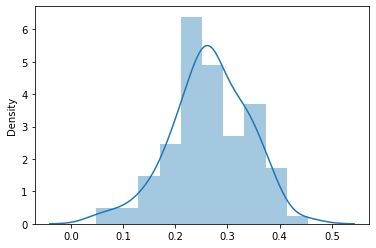

In [51]:
coverages = []
for country in countries:
    country_holidays = holidays[(holidays['CountryCode']==country) & (holidays['Type']=='Public')]
    if len(country_holidays) > 0:
        n_country_holidays_covered = 0
        for country_holiday in country_holidays.index:
            if country_holiday in stores_off.index:
                n_country_holidays_covered += 1
        holidays_covered_by_days_off = (n_country_holidays_covered / len(country_holidays))
        if holidays_covered_by_days_off > .33:
            print(country, countries[country],
                  n_country_holidays_covered, len(country_holidays), 
                  '%.2f' % holidays_covered_by_days_off)
        coverages.append(holidays_covered_by_days_off)
sns.distplot(coverages)

Again, nothing definitive - apart from slight suspect its the Ukraine, or Uruguay, which can easly be the random coincidence

### Conclusion 1
The stores seem to follow the world wide holidays schedule in the part of Christmas, NYE and couple religious events.
It is not possible to determine the country basing on the holidays schedule.

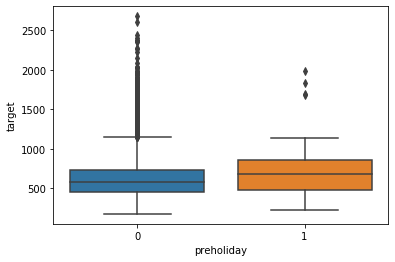

In [75]:
days_off_wwide_holidays = \
   ['2016-01-01', '2016-01-06', '2016-12-25', '2016-12-26', '2017-01-01', 
    '2016-05-01', '2017-05-01', '2017-05-25', '2016-06-19', '2017-06-04',
    '2016-06-09']

days_off_wwide_preholidays = \
   ['2016-01-05', '2016-12-24', '2016-12-31', '2016-04-30', '2017-04-30',
    '2017-05-24', '2016-06-18', '2017-06-03', '2016-06-08']
    
days_off_wwide_holidays = [pd.Timestamp(doff) for doff in days_off_wwide_holidays]
days_off_wwide_preholidays = [pd.Timestamp(doff) for doff in days_off_wwide_preholidays]

train['preholiday'] = train.apply(lambda row: 
            (1 if (row.name[1] in days_off_wwide_preholidays) else 0), axis=1)
sns.boxplot(x='preholiday', y='target', data=train)
plt.show()

### Conclusion 2
The pre-holiday day feature may make sence